In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
import re
import lfrData

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
G_lfr=nx.Graph()
data,labels=lfrData.load_data(0.3)

for index,item in enumerate(labels):
    G_lfr.add_node(index+1,value=item)
for item in data:
    G_lfr.add_edge(*item)
B_lfr = nx.modularity_matrix(G_lfr)

In [3]:
c_attributes = nx.get_node_attributes(G_lfr,'value')
print(c_attributes)

{1: 1, 2: 4, 3: 2, 4: 1, 5: 1, 6: 1, 7: 3, 8: 2, 9: 3, 10: 2, 11: 2, 12: 2, 13: 3, 14: 4, 15: 1, 16: 1, 17: 1, 18: 3, 19: 1, 20: 2, 21: 2, 22: 4, 23: 2, 24: 4, 25: 3, 26: 2, 27: 3, 28: 2, 29: 2, 30: 4, 31: 4, 32: 3, 33: 2, 34: 2, 35: 3, 36: 4, 37: 4, 38: 3, 39: 2, 40: 4, 41: 3, 42: 3, 43: 2, 44: 4, 45: 1, 46: 2, 47: 3, 48: 1, 49: 4, 50: 1, 51: 4, 52: 1, 53: 1, 54: 3, 55: 2, 56: 2, 57: 4, 58: 1, 59: 1, 60: 4, 61: 3, 62: 4, 63: 2, 64: 2, 65: 2, 66: 4, 67: 2, 68: 2, 69: 4, 70: 3, 71: 1, 72: 3, 73: 1, 74: 3, 75: 2, 76: 4, 77: 1, 78: 2, 79: 3, 80: 3, 81: 2, 82: 2, 83: 4, 84: 3, 85: 4, 86: 4, 87: 1, 88: 1, 89: 1, 90: 3, 91: 3, 92: 4, 93: 3, 94: 4, 95: 3, 96: 2, 97: 2, 98: 1, 99: 1, 100: 3, 101: 1, 102: 3, 103: 4, 104: 1, 105: 1, 106: 4, 107: 2, 108: 3, 109: 1, 110: 2, 111: 1, 112: 4, 113: 3, 114: 4, 115: 1, 116: 1, 117: 2, 118: 1, 119: 4, 120: 4, 121: 3, 122: 3, 123: 1, 124: 3, 125: 4, 126: 4, 127: 3, 128: 4}


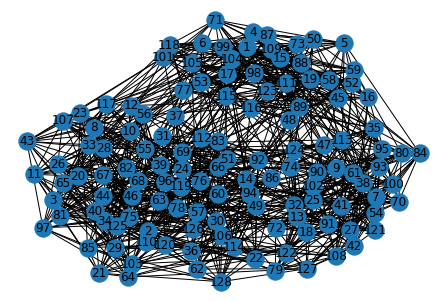

In [4]:
nx.draw(G_lfr,with_labels=True)

In [5]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [6]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.01)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        return encoder,reconstructed

In [7]:
learning_rate = 1e-3

In [8]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=128)
model2=AE(hidden_layers=32,in_layers=64)
model3=AE(hidden_layers=16,in_layers=32)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=128, out_features=64, bias=True)
  (encoder_output_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_output_layer): Linear(in_features=64, out_features=128, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)


In [9]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [10]:
B_lfr=np.asarray(B_lfr,dtype=np.float64)
inputs=torch.from_numpy(B_lfr)
targets=torch.from_numpy(B_lfr)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist=train_model(300,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist=train_model(200,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
encoder,hist=train_model(300,train_dl,model3,optimizer3)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

epoch : 1/300, recon loss = 0.11743196
epoch : 2/300, recon loss = 0.11553760
epoch : 3/300, recon loss = 0.11382935
epoch : 4/300, recon loss = 0.11227584
epoch : 5/300, recon loss = 0.11084755
epoch : 6/300, recon loss = 0.10951758
epoch : 7/300, recon loss = 0.10826186
epoch : 8/300, recon loss = 0.10705933
epoch : 9/300, recon loss = 0.10589198
epoch : 10/300, recon loss = 0.10474470
epoch : 11/300, recon loss = 0.10360512
epoch : 12/300, recon loss = 0.10246358
epoch : 13/300, recon loss = 0.10131314
epoch : 14/300, recon loss = 0.10014985
epoch : 15/300, recon loss = 0.09897298
epoch : 16/300, recon loss = 0.09778523
epoch : 17/300, recon loss = 0.09659278
epoch : 18/300, recon loss = 0.09540476
epoch : 19/300, recon loss = 0.09423219
epoch : 20/300, recon loss = 0.09308608
epoch : 21/300, recon loss = 0.09197532
epoch : 22/300, recon loss = 0.09090476
epoch : 23/300, recon loss = 0.08987460
epoch : 24/300, recon loss = 0.08888137
epoch : 25/300, recon loss = 0.08792022
epoch : 2

In [11]:
B_lfr_X=encoder.detach().numpy()

In [12]:
print(type(B_lfr_X),B_lfr_X)

<class 'numpy.ndarray'> [[-0.17281134  0.2090332  -0.5228413  ...  0.06931482  0.01435667
  -0.02996662]
 [ 0.35146034  0.5505191  -0.3720783  ... -0.38687637 -0.3495313
  -0.18789949]
 [ 0.46065882  0.4271197   0.38026983 ... -0.18560663  0.12972683
   0.14019576]
 ...
 [ 0.3411357  -0.39575955  0.37665787 ... -0.25367498 -0.05730242
   0.23726687]
 [ 0.09209871  0.36655334  0.4028404  ... -0.79555094  0.06965517
   0.63651717]
 [ 0.14465389  0.11029118 -0.45673734 ... -0.35679245  0.16286856
   0.31211483]]


In [15]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=19)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_

c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[2 3 0 2 2 2 1 0 1 0 0 0 1 3 2 2 2 1 2 0 0 3 0 3 1 0 1 0 0 3 3 1 0 0 1 3 3
 1 0 3 1 1 0 3 2 0 1 2 3 2 3 2 2 1 0 0 3 2 2 3 1 3 0 0 0 3 0 0 3 1 2 1 2 1
 0 3 2 0 1 1 0 0 3 1 3 3 2 2 2 1 1 3 1 3 1 0 0 2 2 1 2 1 3 2 2 1 0 1 2 0 2
 3 1 3 2 1 0 2 3 3 1 1 2 1 3 3 1 3]
[1 4 2 1 1 1 3 2 3 2 2 2 3 4 1 1 1 3 1 2 2 4 2 4 3 2 3 2 2 4 4 3 2 2 3 4 4
 3 2 4 3 3 2 4 1 2 3 1 4 1 4 1 1 3 2 2 4 1 1 4 3 4 2 2 2 4 2 2 4 3 1 3 1 3
 2 4 1 2 3 3 2 2 4 3 4 4 1 1 1 3 3 4 3 4 3 2 2 1 1 3 1 3 4 1 1 4 2 3 1 2 1
 4 3 4 1 1 2 1 4 4 3 3 1 3 4 4 3 4]


0.9495696906784283

In [14]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_lfr_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_lfr,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.7511088000309862
Epoch:2 1 0.7511088000309862
Epoch:3 1 0.7511088000309862
Epoch:4 4 0.9321108129314574
Epoch:5 4 0.9321108129314574
Epoch:6 4 0.9321108129314574
Epoch:7 4 0.9321108129314574
Epoch:8 4 0.9321108129314574
Epoch:9 4 0.9321108129314574
Epoch:10 4 0.9321108129314574
Epoch:11 4 0.9321108129314574
Epoch:12 4 0.9321108129314574
Epoch:13 4 0.9321108129314574
Epoch:14 4 0.9321108129314574
Epoch:15 4 0.9321108129314574
Epoch:16 4 0.9321108129314574
Epoch:17 4 0.9321108129314574
Epoch:18 4 0.9321108129314574
Epoch:19 19 0.9495696906784283
Epoch:20 19 0.9495696906784283
Epoch:21 19 0.9495696906784283
Epoch:22 19 0.9495696906784283
Epoch:23 19 0.9495696906784283
Epoch:24 19 0.9495696906784283
Epoch:25 19 0.9495696906784283
Epoch:26 19 0.9495696906784283
Epoch:27 19 0.9495696906784283
Epoch:28 19 0.9495696906784283
Epoch:29 19 0.9495696906784283
Epoch:30 19 0.9495696906784283
Epoch:31 19 0.9495696906784283
Epoch:32 19 0.9495696906784283
Epoch:33 19 0.9495696906784283
Epoc

In [16]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=614)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_
labels_dict={0:[],1:[],2:[],3:[]}
for index,item in enumerate(X_ae):
    labels_dict[item].append(index+1)
print(labels_dict)

{0: [7, 16, 18, 19, 24, 32, 38, 42, 47, 50, 70, 71, 72, 74, 84, 90, 91, 93, 98, 100, 102, 106, 109, 113, 122, 123, 124], 1: [2, 14, 17, 22, 30, 31, 36, 37, 40, 44, 49, 51, 57, 59, 60, 62, 66, 69, 76, 83, 85, 86, 87, 88, 92, 94, 99, 103, 112, 114, 115, 119, 120, 125, 126, 128], 2: [3, 8, 10, 11, 12, 20, 21, 23, 26, 28, 29, 33, 34, 39, 43, 46, 53, 55, 56, 63, 64, 65, 67, 68, 75, 78, 81, 82, 96, 97, 107, 110, 117], 3: [1, 4, 5, 6, 9, 13, 15, 25, 27, 35, 41, 45, 48, 52, 54, 58, 61, 73, 77, 79, 80, 89, 95, 101, 104, 105, 108, 111, 116, 118, 121, 127]}


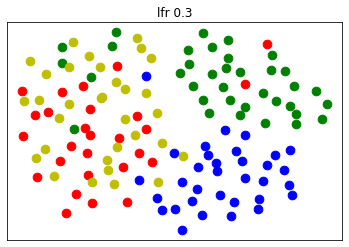

In [17]:
G=G_lfr
pos=nx.spring_layout(G)
# print(pos)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[0],node_color='r',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[1],node_color='g',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[2],node_color='b',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[3],node_color='y',node_size=75)

plt.title('lfr 0.3')
plt.show()

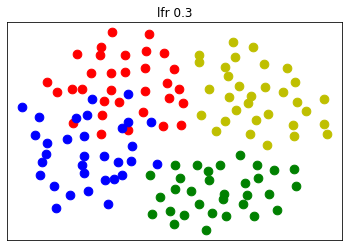

In [18]:
c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
labels_dict={1:[],2:[],3:[],4:[]}
for index,item in enumerate(X_gt):
    labels_dict[item].append(index+1)

G=G_lfr
pos=nx.spring_layout(G)
# print(pos)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[1],node_color='r',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[2],node_color='g',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[3],node_color='b',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[4],node_color='y',node_size=75)

plt.title('lfr 0.3')
plt.show()